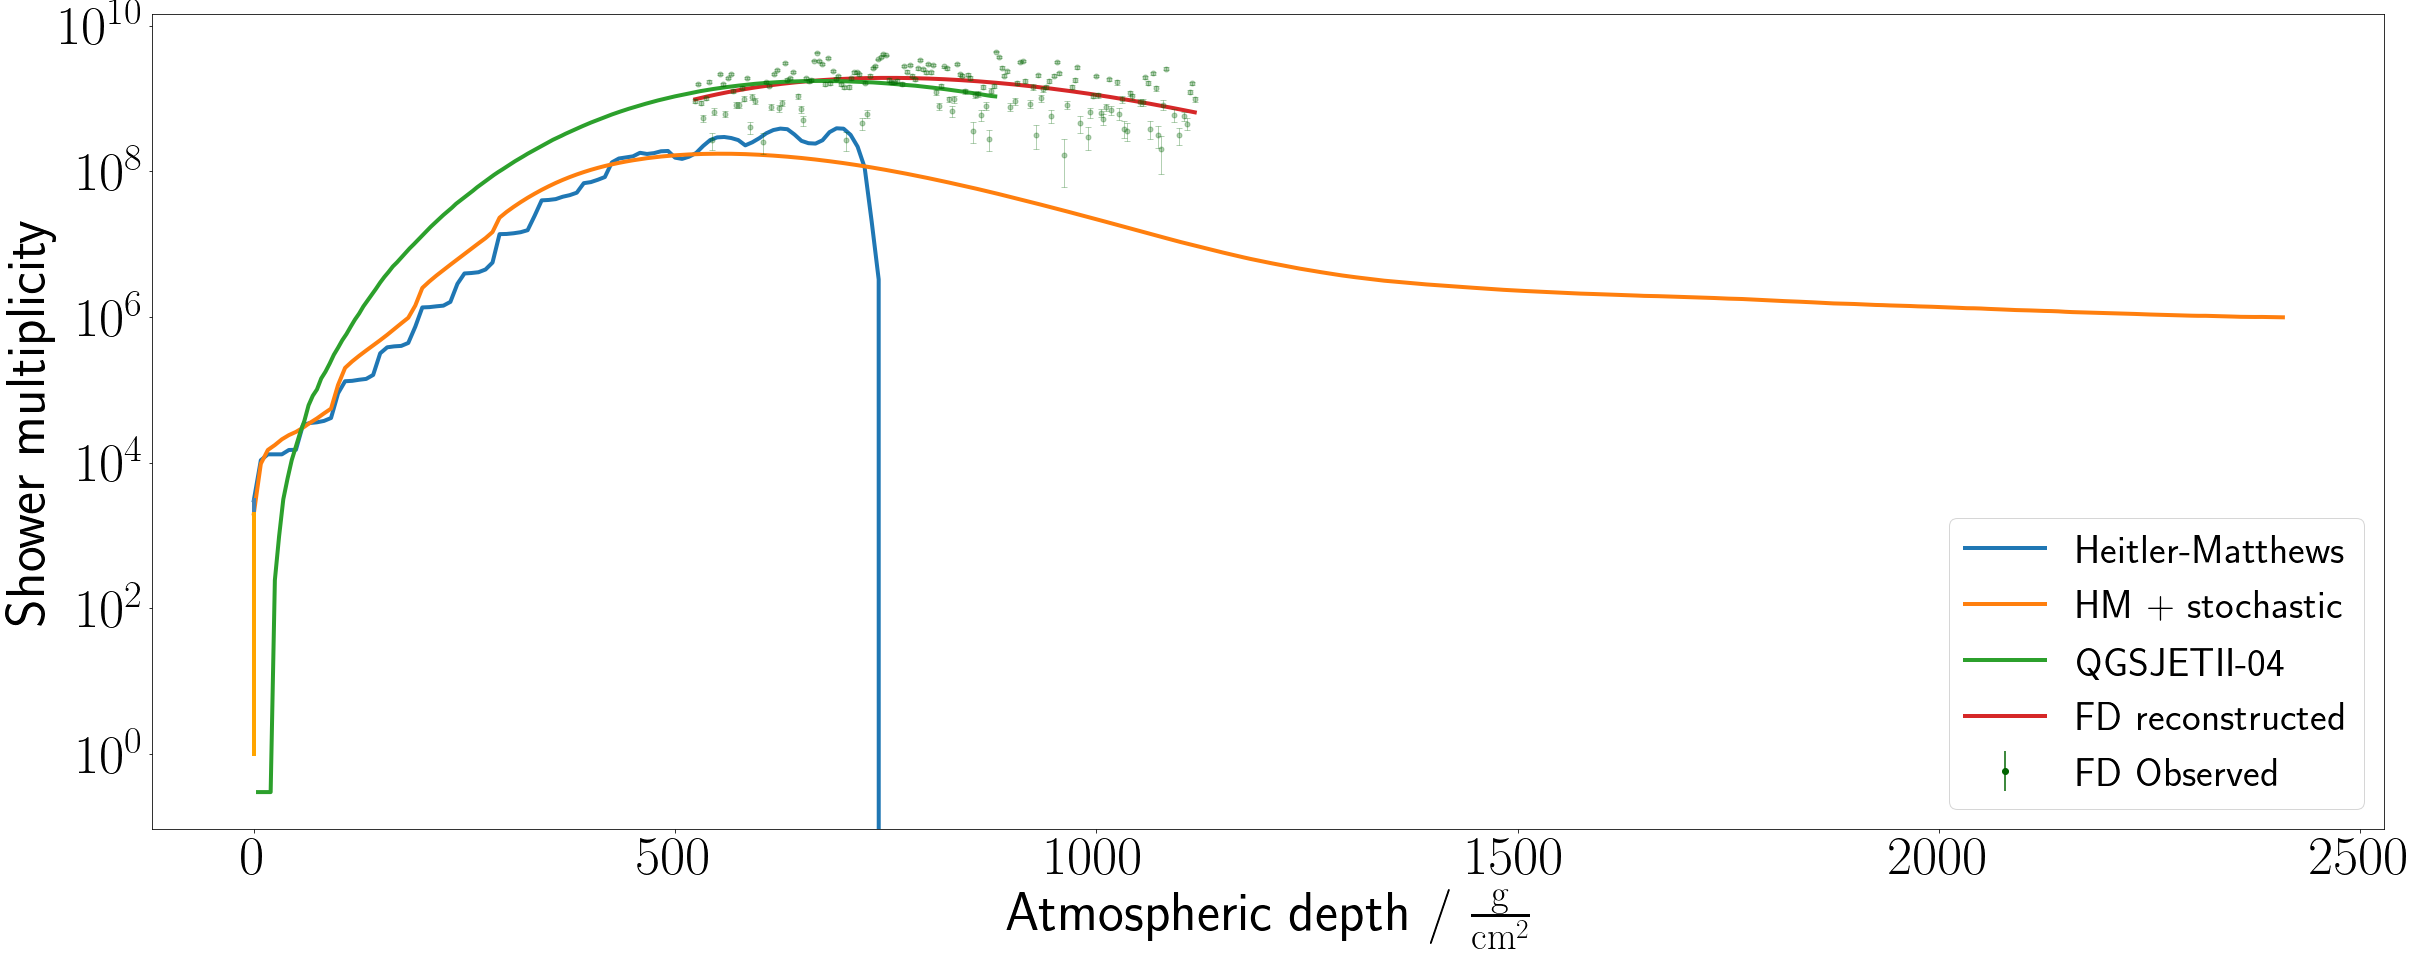

In [2]:
from Binaries import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

plt.rcParams["font.size"] = 55

with open('Auger_051035232600.json', "r") as file_content:  
    data = json.load(file_content)

eyes = pd.DataFrame(data['eyes'])
fdrec = pd.DataFrame(data['fdrec'])
sdrec = pd.DataFrame(data['sdrec'])

observed_energy = np.unique(sdrec['energy'])[0]

#######

for idx, eye in eyes.merge(fdrec, how='inner').iterrows():
        L = eye.uspL
        R = eye.uspR
        Xmax = eye.xmax
        dEdXmax = eye.dEdXmax
        factor = 5 * 10**8

        atm_fields = ["atmDepthProf", "energyDepositProf", "denergyDepositProf"]
        profile = pd.DataFrame(dict(zip(atm_fields, eye[atm_fields])))

        depth_observed, observed = profile.atmDepthProf, dEdXmax*pow(1 + R*(profile.atmDepthProf-Xmax)/L, pow(R,-2)) * np.exp(-(profile.atmDepthProf-Xmax) / (R*L)) * factor
        measurements, measurements_err = profile.energyDepositProf * factor, profile.denergyDepositProf * factor

depth_simulated, GAMMAS, POSITRONS, ELECTRONS, MUp, MUm, HADRONS, CHARGED, NUCLEI, CHERENKOV = np.loadtxt("gammas.txt", unpack = True)
simulated = CHARGED

depth_deterministic, nuclei, pions, electrons, photons, muons, neutrinos, remainin_energy, ionization = np.loadtxt('./showersim/result_deterministic.txt', unpack=True)
heitler_matthews_deterministic = nuclei + pions + electrons + muons

depth_stochastic, nuclei, pions, electrons, photons, muons, neutrinos, remainin_energy, ionization = np.loadtxt('./showersim/result_random.txt', unpack=True)
heitler_matthews_stochastic = nuclei + pions + electrons + muons

observed_extended = dEdXmax*pow(1 + R*( ((depth_deterministic[10:] - depth_deterministic[10]) / 8) -Xmax)/L, pow(R,-2)) * np.exp(-( ((depth_deterministic[10:] - depth_deterministic[10]) / 8) -Xmax) / (R*L)) * factor

plt.plot((depth_deterministic[10:] - depth_deterministic[10]) / 8, heitler_matthews_deterministic[10:] * 100, label = "Heitler-Matthews", lw = 4)
plt.plot((depth_stochastic[10:] - depth_deterministic[10]) / 8, heitler_matthews_stochastic[10:] * 100, label = "HM + stochastic", lw = 4)
# plt.plot((depth_deterministic[10:] - depth_deterministic[10]) / 8, observed_extended, label ="FD reconstructed", zorder = 1, lw = 4)
plt.plot(depth_simulated, simulated * 0.3, label = "QGSJETII-04", lw = 4)
plt.errorbar(depth_observed[measurements > 10**8], measurements[measurements > 10**8], yerr = measurements_err[measurements > 10**8] / 10, linestyle='', marker='o', alpha=0.3, markersize=5, linewidth=1, capsize = 3, c = "darkgreen")
plt.errorbar([],[], yerr = [], fmt = "o", capsize = 3, c = "darkgreen", label = "FD Observed")
plt.plot(depth_observed, observed, label ="FD reconstructed", zorder = 1, lw = 4)

plt.plot([0, 0], [1, heitler_matthews_deterministic[10] * 100], c = "steelblue", lw = 4)
plt.plot([0, 0], [1, heitler_matthews_stochastic[10] * 100], c = "orange", lw = 4)

plt.rcParams["figure.figsize"] = [40, 15]

plt.yscale("log")
plt.legend(prop={'size': 40})

plt.xlabel(r"Atmospheric depth / $\frac{\mathrm{g}}{\mathrm{cm}^{2}}$")
plt.ylabel("Shower multiplicity")

plt.savefig("../../plots/validity_plot.png")
plt.show()